In [590]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [591]:
rgb_img = cv2.imread('pc_test/rgb_0.jpg')
depth_img = cv2.imread('pc_test/depth_0.png',cv2.IMREAD_UNCHANGED)

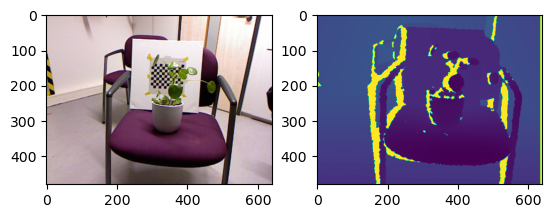

In [592]:
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(rgb_img[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(depth_img)

In [593]:
class camera():
    def __init__(self):

        self.ir_intrinsic_matrix = np.array(
            [[583.334961345953, 0, 333.449731805028],
             [0, 583.536965483492, 236.563413051087], [0, 0, 1]])
        self.ir_distortion_matrix = np.array([-0.0557307630488867, 0.111059311588260, 0, 0, 0])
        self.rgb_intrinsic_matrix = np.array(
            [[533.251582651622, 0, 318.2918744903051],
             [0, 532.858110789750, 257.810213634179], [0, 0, 1]])
        self.rgb_distortion_matrix = np.array(
            [0.209252073349094, -0.438956630699146, 0, 0, 0])

        self.A = np.array([[
            0.999980636769351, -0.00482933069483759, 0.0119631085329259,
            -24.6
        ],
                           [
                               0.00488969819855569, 0.999918558578594,
                               -0.00502203953786087, -2
                           ],
                           [
                               0.00119330935703847, 0.00508011758059752,
                               0.999936578329645, -1
                           ]])
        self.imgsize = (640,480)

In [594]:
kinect = camera()
camera_matrix,_ = cv2.getOptimalNewCameraMatrix(kinect.rgb_intrinsic_matrix, kinect.rgb_distortion_matrix, kinect.imgsize, 1, kinect.imgsize)

In [595]:
camera_matrix

array([[503.83990479,   0.        , 316.76445748],
       [  0.        , 510.29452515, 261.73419589],
       [  0.        ,   0.        ,   1.        ]])

In [596]:
# hole_filter = HoleFilling_Filter(flag='fmi',min_valid_depth=200, max_valid_depth=500.)
# hf_image = hole_filter.smooth_image(depth_img)
# hole_filter = HoleFilling_Filter(flag='min')
# hf_image = hole_filter.smooth_image(depth_img)
# print('hole filled image frames (filled invalid values)')
# plt.imshow(hf_image)
# hf_image = kinect_preprocess(depth_img)

In [597]:
# depth_img[np.where(depth_img<1000)]=np.nan
# dist = 123.6* np.tan(depth_img/2842.5 + 1.1863 )*1000
# dist = 1.0/(depth_img *(-0.0030711016)+3.3309495161)*1000
# # dist[dist<0]=np.nan
# dist = 0.075*585/(1090-undistorted_depth_img)*8*1000
# epsilon = 1e-20  # A small constant to avoid division by zero
# dist = 0.075 * 583*(1090 - depth_img + epsilon) * 8*1000 
# depth_img.shape
depth_img[depth_img==0]=2047
depth_img[depth_img==1090]=2047
dist = 0.075*583/(1090-depth_img) * 8 *1000


# dist[np.where(dist>1800)] = np.nan
dist[dist <0] = np.nan
dist[dist >2300] = np.nan

In [598]:
# dist = 123.6* np.tan(depth_img/2842.5 + 1.1863 )


In [599]:
cx_ir = kinect.ir_intrinsic_matrix[0,2]
cy_ir = kinect.ir_intrinsic_matrix[1,2]
fx_ir = kinect.ir_intrinsic_matrix[0,0]
fy_ir = kinect.ir_intrinsic_matrix[1,1]

In [600]:
def pixel2world(x,y,intrinsic_matrix, dist):
    cx = intrinsic_matrix[0,2]
    cy = intrinsic_matrix[1,2]
    fx = intrinsic_matrix[0,0]
    fy = intrinsic_matrix[1,1]
    Z = dist[y, x]
    X = (x - cx) * Z / fx
    Y = (y - cy) * Z / fy
    return X, Y ,Z
    

In [601]:
x = np.tile(np.arange(640), (480, 1))
y = np.tile(np.arange(480).reshape(-1, 1), (1, 640))
X,Y,Z = pixel2world(x,y,kinect.ir_intrinsic_matrix, dist)
# Flatten the matrices
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()

# Combine into a single array of 3D points
points_3d = np.vstack((X_flat, Y_flat, Z_flat)).T

In [602]:
pixel2world(x,y,kinect.ir_intrinsic_matrix, dist)[0].shape

(480, 640)

In [603]:
points_3d.shape

(307200, 3)

<Axes: ylabel='Frequency'>

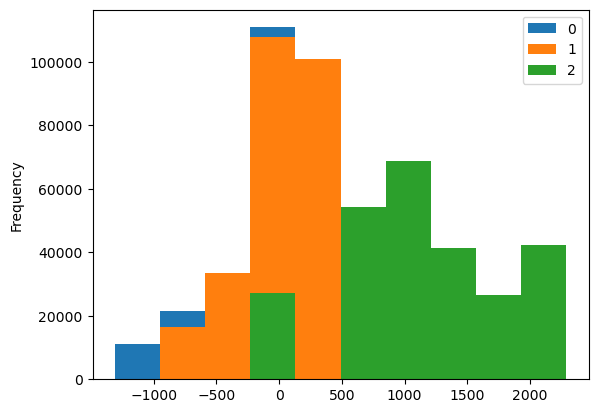

In [604]:
df_point_3d = pd.DataFrame(points_3d[:,:3])
df_point_3d.plot.hist(df_point_3d)

In [605]:
points_3d

array([[-1136.1077012 ,  -805.72407791,  1987.5       ],
       [-1132.70056785,  -805.72407791,  1987.5       ],
       [-1135.74653984,  -810.3282155 ,  1998.85714286],
       ...,
       [    2.81864969,     2.25039253,     5.4166215 ],
       [    2.8279353 ,     2.25039253,     5.4166215 ],
       [    2.83722091,     2.25039253,     5.4166215 ]])

In [606]:
import open3d as o3d
import numpy as np
FOR1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
# Let's say 'points_3d' is your array of 3D points (numpy array)
# points_3d.shape should be (N, 3), where N is the number of points

# Create an Open3D point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)

# Visualize the point cloud
# o3d.visualization.draw_geometries([pcd,FOR1])

In [607]:
points_3d.shape

(307200, 3)

In [608]:
points_3d = np.append(points_3d.T, np.ones((1,points_3d.shape[0])),axis=0).T

In [609]:
raw_pixel = (kinect.rgb_intrinsic_matrix).dot(kinect.A).dot(points_3d.T).T



In [610]:
rgb_pixel = np.round((raw_pixel/(raw_pixel[:,-1].reshape(-1,1)))).astype(int)

C:\Users\Hao Xu\AppData\Local\Temp\ipykernel_25300\2923931570.py:1: RuntimeWarning: invalid value encountered in cast
  rgb_pixel = np.round((raw_pixel/(raw_pixel[:,-1].reshape(-1,1)))).astype(int)


In [611]:
rgb_pixel

array([[   13,    36,     1],
       [   14,    36,     1],
       [   15,    36,     1],
       ...,
       [-2296,   286,     1],
       [-2295,   286,     1],
       [-2294,   286,     1]])

<Axes: ylabel='Frequency'>

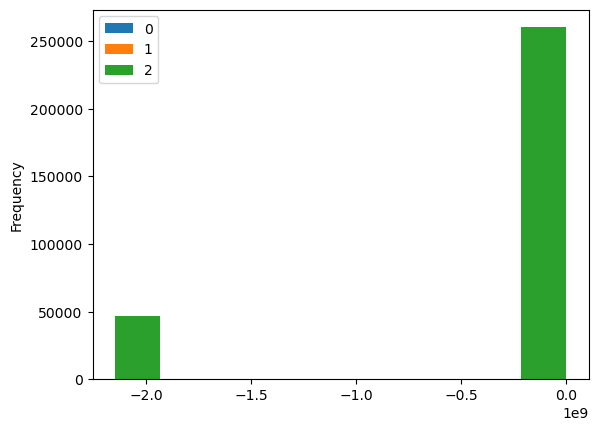

In [612]:
df_rgb_pixel = pd.DataFrame(rgb_pixel)
df_rgb_pixel.plot.hist()

In [613]:
h = points_3d.shape[0]
points_3d_color  = np.zeros((h,3))

In [614]:
undistorted_img = cv2.undistort(rgb_img,kinect.rgb_intrinsic_matrix,kinect.rgb_distortion_matrix)
for i,v in enumerate(points_3d):
    x,y = rgb_pixel[i][:2]
    if y>=480 or x>=640:
        pc =  np.array([np.nan,np.nan,np.nan])
    elif  rgb_pixel[i][0]<0 or rgb_pixel[i][1]<0:
        pc = np.array([np.nan,np.nan,np.nan])
    else:
        y,x = rgb_pixel[i][:2]

#         print(x,y)
        pc = undistorted_img[x,y]
    points_3d_color[i] = pc
    

In [615]:
# Creating a point cloud object
pcd = o3d.geometry.PointCloud()

# points_3d = points_3d[~np.isnan(points_3d)]
# Assigning the points
pcd.points = o3d.utility.Vector3dVector(points_3d[:, :3])

# Assigning the colors
pcd.colors = o3d.utility.Vector3dVector(points_3d_color[:,[2, 1, 0]]/ 255.0)
FOR1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=200, origin=[0, 0, 0])

# Visualizing the point cloud
o3d.visualization.draw_geometries([pcd,FOR1])